In [ ]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

from keras import models, layers, optimizers, metrics, activations, losses
from keras.datasets import mnist
from keras import backend as K


In [2]:
batch_size = 100
original_dim = 784
epsilon = 1e-20
min_temperature = 0.5
anneal_rate = 0.0003

tau = K.variable(1.0, name="temperature")
C = 10 # Number of classes (K in paper)
N = 30 # Number of categorical distributions

# latent_dim = 2
# intermediate_dim = 256
# epochs = 50
# epsilon_std = 1.0

# Setup network and loss

In [7]:
img_input = layers.Input(shape=(original_dim,))

# Encoder
x = layers.Dense(512, activation='relu')(img_input)
x = layers.Dense(256, activation='relu')(x)

# Unnormalized logits for N separate K-categorical distributions
logits_y = layers.Dense(C*N, activation=None)(x)

# Sampling function (keras specific implementation)
def gumbel_sampling(logits_y):
    """ Draw a sample from the Gumbel-Softmax distribution"""
    epsilon = 1e-20
    
    # Sample form Gumbel(0, 1)
    uniform_sample = K.random_uniform(shape=(K.shape(logits_y)), minval=0, maxval=1)
    gumbel_sample = - K.log(- K.log(uniform_sample + epsilon) + epsilon)

    y = logits_y + gumbel_sample
    y = K.softmax(K.reshape(y, shape=(-1, N, C))) / tau
    
    return K.reshape(y, shape=(-1, C*N))

z = layers.Lambda(gumbel_sampling, output_shape=(C*N,))(logits_y)

# Decoder
x = layers.Dense(256, activation='relu')(z)
x = layers.Dense(512, activation='relu')(x)
img_output = layers.Dense(original_dim, activation='sigmoid')(x)


# Loss function
def gumbel_loss(img_in, img_out):
    bce = losses.binary_crossentropy (img_in, img_out)
    q_y = K.softmax(logits_y)
    log_q_y = K.log(q_y + epsilon)
    KL_temp = K.reshape(q_y * (log_q_y - K.log(1.0 / C)), shape=(-1, N, C))
    KL = K.sum(KL_temp, axis=(1,2)) # Reduce in all axes
    #Variational autoencoders minimizes reconstruction error of the data by maximizing an expectedlower bound (ELBO) on the likelihood of the data, under a generative model
    elbo = original_dim * bce - KL

    return elbo

vae = models.Model(img_input, img_output)
vae.summary()
vae.compile(optimizer='adam', loss=gumbel_loss)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 300)               77100     
_________________________________________________________________
lambda_2 (Lambda)            (None, 300)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               77056     
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
__________

# Load MNIST data

In [8]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [9]:
x_train.shape
x_test.shape

(10000, 784)

# Train network

In [198]:
for e in range(1):
    vae.fit(x_train, x_train,
        shuffle=True,
        epochs=1,
        batch_size=batch_size,
        validation_data=(x_test, x_test))
    K.set_value(tau, np.max([K.get_value(tau) * np.exp(- anneal_rate * e), min_temperature]))
    
    print(K.get_value(tau))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 75s 1ms/step - loss: 64.3373 - val_loss: 68.8274
0.5


# Image -> encoding -> reconstruction

In [55]:
argmax_y = K.max(K.reshape(logits_y, (-1, N, C)), axis=-1, keepdims=True)
argmax_y = K.equal(K.reshape(logits_y, (-1, N, C)), argmax_y)
encoder = K.function([img_input], [argmax_y, img_output])

decoder = K.function([logits_y], [img_output])

(100, 30, 10)


(-0.5, 27.5, 27.5, -0.5)

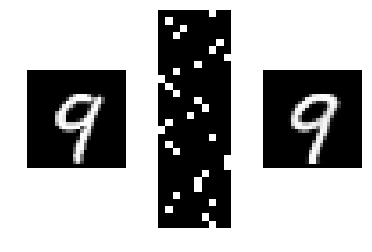

In [56]:
code, x_hat_test = encoder([x_test[:100]])

print(code.shape)

plt.subplot(131)
plt.imshow(x_test[12].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(code[12].reshape(N, C), cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(x_hat_test[12].reshape(28, 28), cmap='gray')
plt.axis('off')


# Generation (1 feature)

Only one feature enabled.

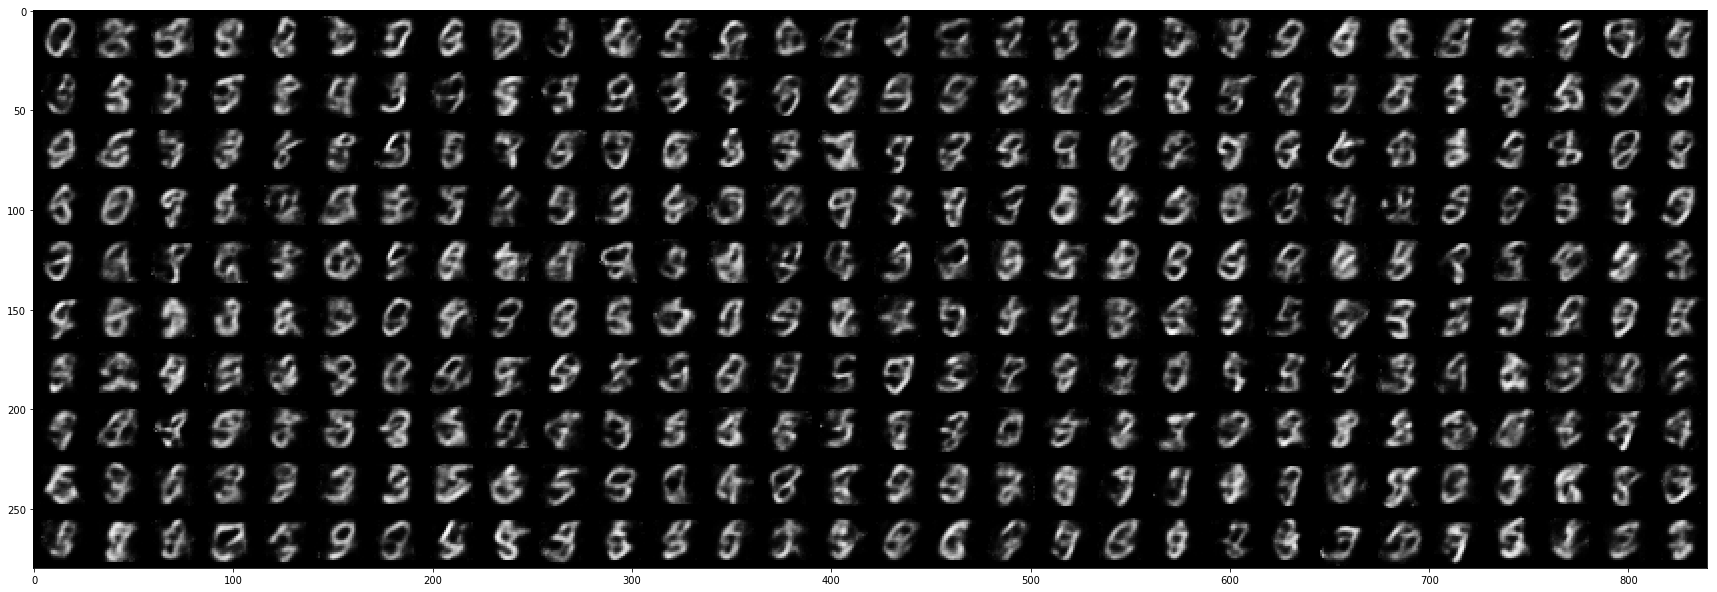

In [57]:
image = np.zeros((28 * C, 28 * N))
for c in range(C):
    for n in range(N):
        
        new_code = np.zeros((1, N, C))
        new_code[0, n, c] = 1
        
        constructed_image = decoder([new_code.reshape(1, C*N)])
        constructed_image = constructed_image[0].reshape(28,28)
        
        image[c * 28: (c + 1) * 28,
              n * 28: (n + 1) * 28] = constructed_image

plt.figure(figsize=(30,30))
plt.imshow(image, cmap='gray')
plt.show()
        



#constructed_image = decoder([code.reshape(-1, C*N)])


# Generation (random embeddings)


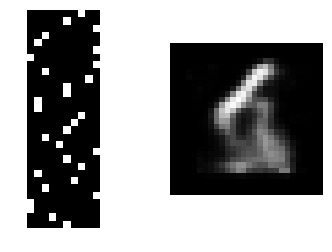

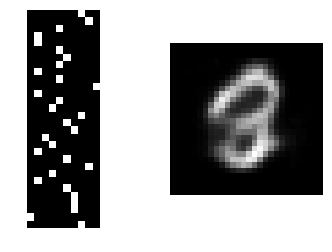

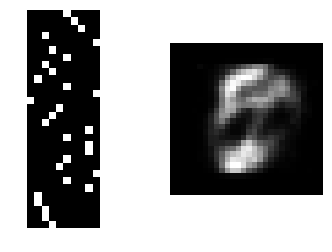

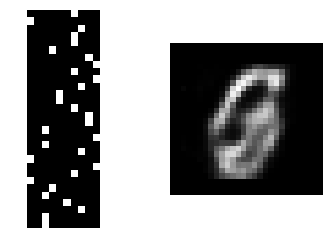

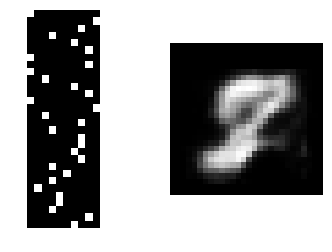

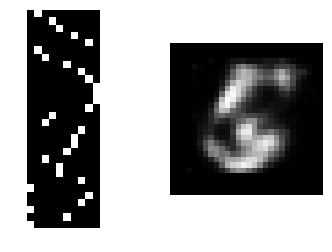

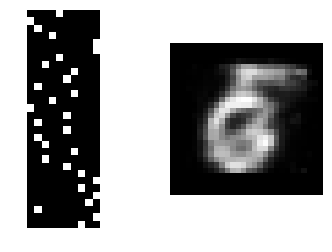

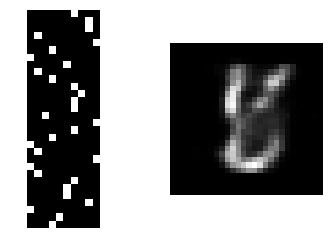

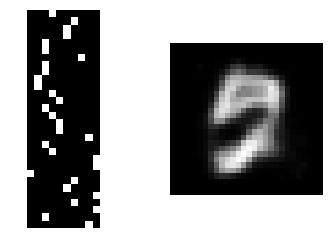

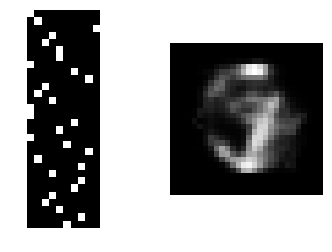

In [58]:
from keras.utils import to_categorical

code_length = C*N
code_base = np.ones(C*N)
examples = 10

for i in range(examples):
    code = to_categorical(np.random.choice(C, size=N)).reshape(1, C*N)
    image = decoder([code])[0].reshape(28,28)
        
    plt.figure()
    plt.subplot(121)
    plt.imshow(code.reshape(N, C), cmap='gray')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [63]:
x_test_sorted = x_test[np.argsort(y_test), :]
y_test_sorted = y_test[np.argsort(y_test)]
print(y_test_sorted.shape)

(10000,)


# Important features per label

In [119]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
    # Inverting the colors seems to look better for MNIST
    #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

## Label (y) vs feature (x)

(980, 30)
(1000, 30)
(1000, 30)
(1000, 30)
(982, 30)
(892, 30)
(958, 30)
(1000, 30)
(974, 30)
(1000, 30)


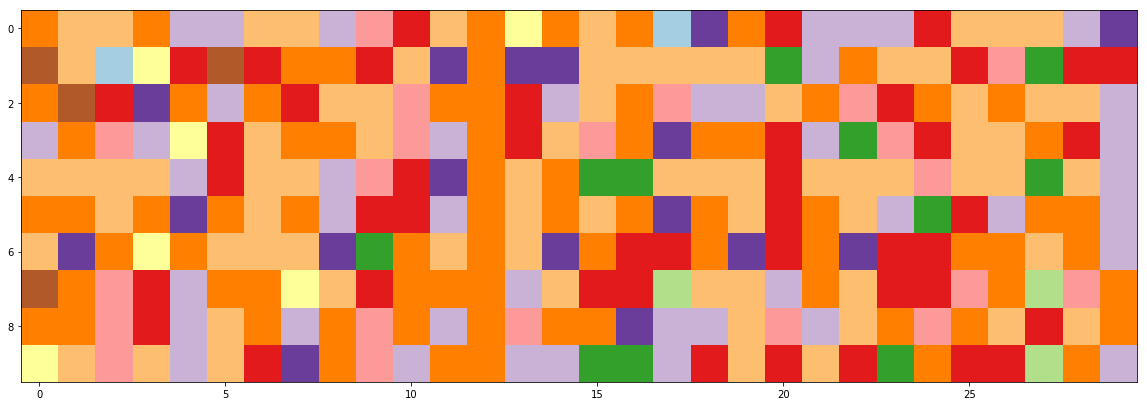

In [180]:
label_map = np.zeros((10, 30))
code_map = np.zeros((100 * 100, 30))

for i in range(10):
    code, x_hat_test = encoder([x_test_sorted[y_test_sorted == i][:1000]])
    
    code_labels = np.argmax(code, axis=2)
    print(code_labels.shape)

    code_map[i*1000:(i*1000)+code_labels.shape[0]] = code_labels
    
    code_sum = code_labels.sum(axis=0)
    label_map[i] = code_sum / code_labels.shape[0]
    
plt.figure(figsize=(20,10))
plt.imshow(label_map, cmap='Paired')
plt.show()


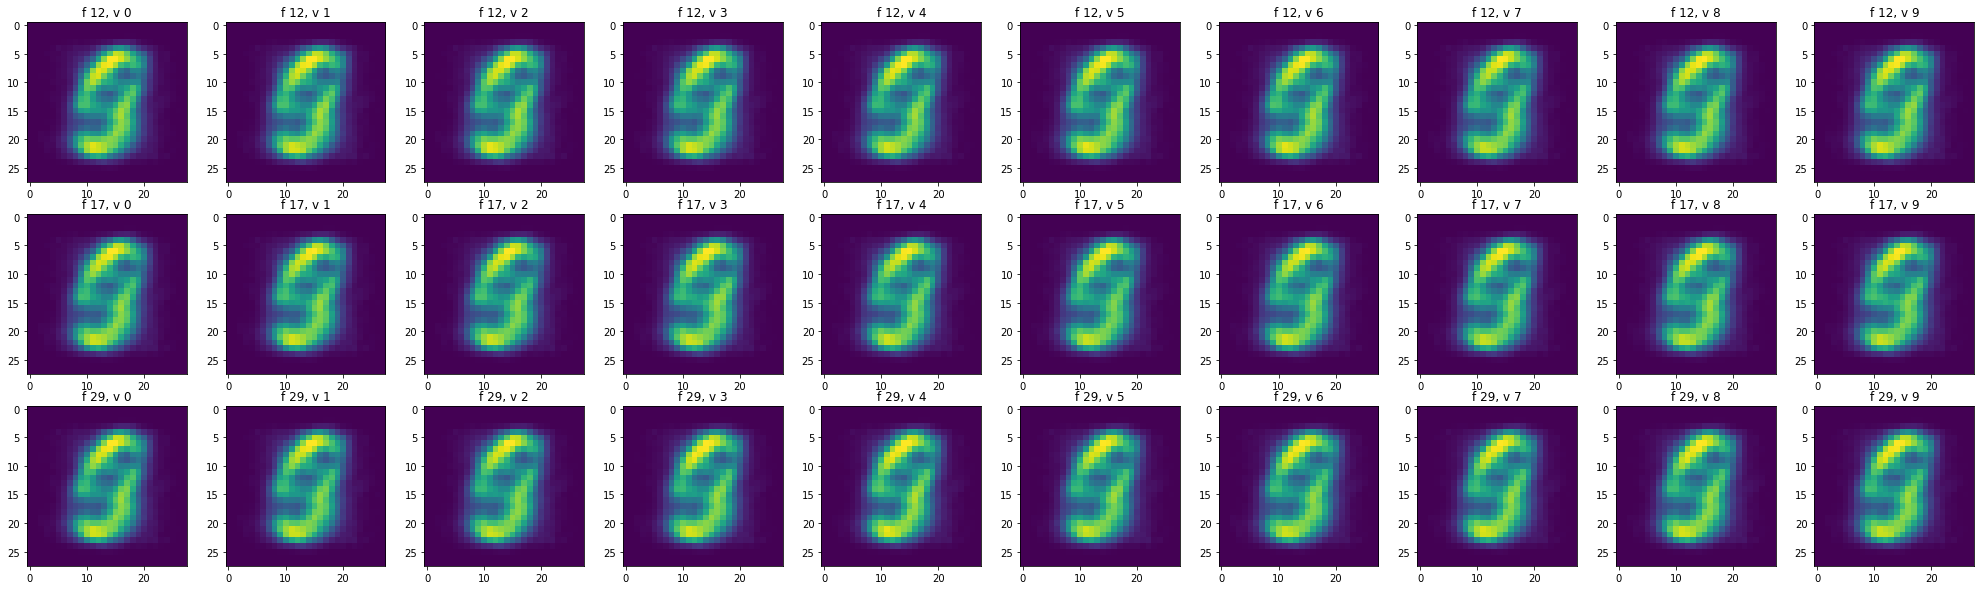

In [197]:
code_length = C*N
code_base = np.ones(C*N)
examples = 1000

features = [12, 17, 29]

fig, axes = plt.subplots(len(features),10, figsize=(35, 10))
for key, f in enumerate(features):
    for v in range(10):
        image = np.zeros((28, 28))
        codes = np.zeros((examples, C*N))
        for i in range(examples):
            numbers = np.zeros(N)#np.random.choice(C, size=N)
            numbers[f] = v # Fix one feature
            categories = to_categorical(numbers, num_classes=10)
            codes[i] = categories.reshape(C*N)
        
        image = decoder([codes])[0].sum(axis=0).reshape(28,28)


        axes[key,v].set_title('f {}, v {}'.format(f, v))
        axes[key,v].imshow(image)
plt.savefig('../feature_examples.png')
plt.show()

(10000, 30)
(600, 600, 3)


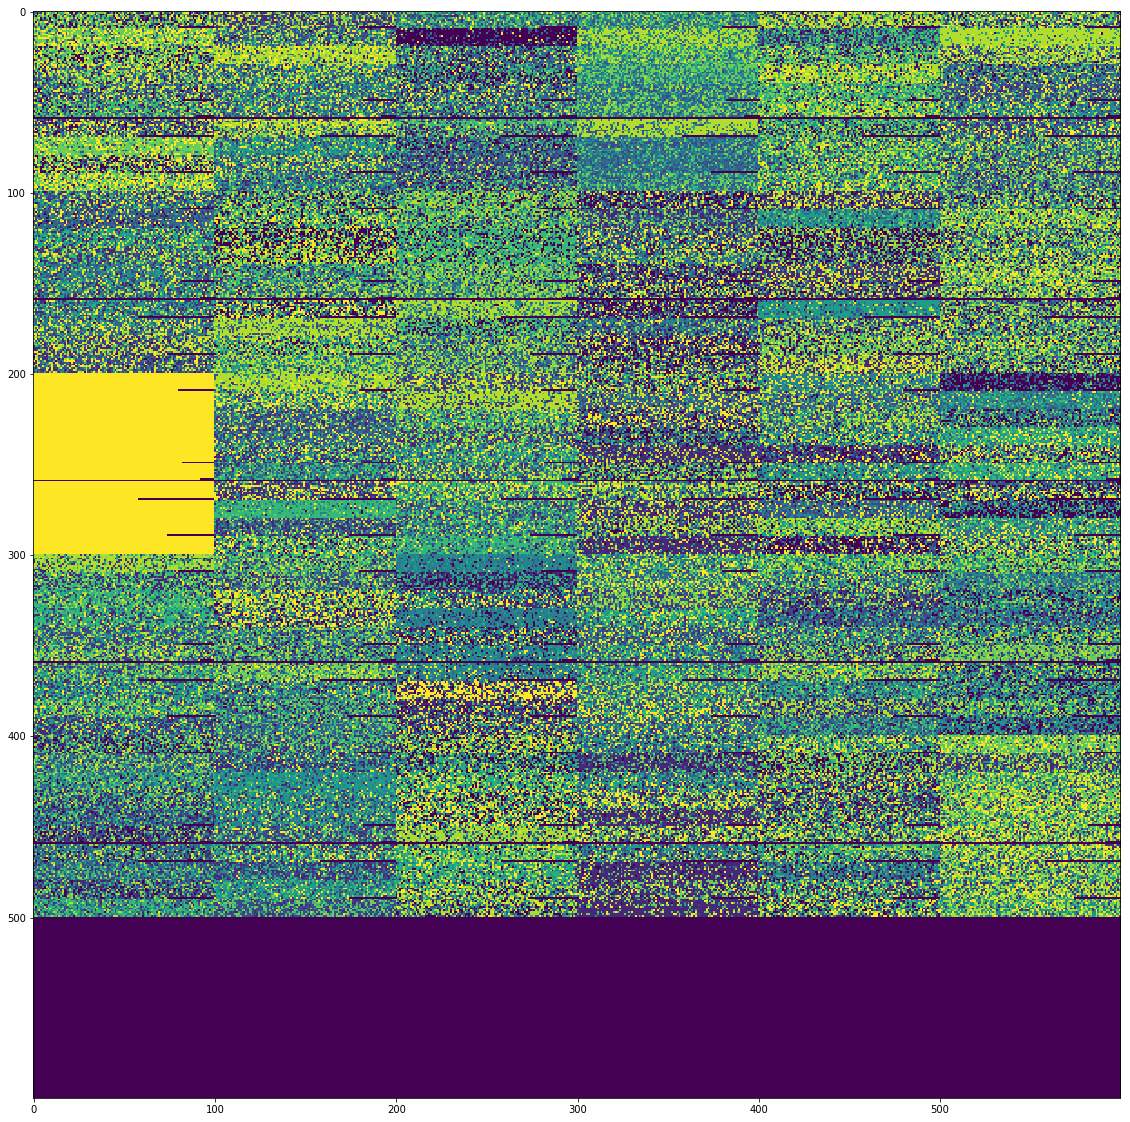

In [138]:
print(code_map.shape)

plt.figure(figsize=(20,20))
sprite = images_to_sprite(code_map.reshape((100,100,30)).transpose(2, 0, 1))
print(sprite.shape)
plt.imshow(sprite[:,:,0])
plt.show()
